In [1]:
!pip install simpletransformers

In [2]:
'''
In choosing RoBERTa for this project, my justification is based on several key points:

Advanced Language Understanding: RoBERTa's deep learning approach is adept at capturing the complexities and nuances of medical terminology, crucial for accurate classification of medical transcriptions.
Contextual Awareness: Its ability to understand context is vital for interpreting medical terms that may have different meanings in different situations.
Efficiency Through Pretraining: Leveraging RoBERTa's pretrained model facilitates transfer learning, allowing for efficient adaptation to the medical domain without the need for extensive domain-specific training data.
Challenges Mitigated: I am conscious of RoBERTa's high computational demands and potential overfitting. I've addressed these through careful validation and efficient use of computational resources, ensuring the model's performance is maximized within the project's constraints.
'''

"\nIn choosing RoBERTa for this project, my justification is based on several key points:\n\nAdvanced Language Understanding: RoBERTa's deep learning approach is adept at capturing the complexities and nuances of medical terminology, crucial for accurate classification of medical transcriptions.\nContextual Awareness: Its ability to understand context is vital for interpreting medical terms that may have different meanings in different situations.\nEfficiency Through Pretraining: Leveraging RoBERTa's pretrained model facilitates transfer learning, allowing for efficient adaptation to the medical domain without the need for extensive domain-specific training data.\nChallenges Mitigated: I am conscious of RoBERTa's high computational demands and potential overfitting. I've addressed these through careful validation and efficient use of computational resources, ensuring the model's performance is maximized within the project's constraints.\n"

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
import nltk
import torch
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
cuda_available = torch.cuda.is_available()

def load_data(file_path):
    """
    Load the data, preprocess, and split into training and test sets.

    Args:
        file_path (str): The path to the CSV file containing the dataset.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets for training and testing.
        num_classes (int): The number of unique classes in the target variable.
        class_weights (list): List of weights for each class (placeholder for now).
        class_dict (dict): Dictionary mapping medical specialties to integer labels.
    """

    # Load dataset
    df = pd.read_csv(file_path)
    df = df.drop(columns=df.columns[0]) #droping unamed column
    # Combine keywords and transcriptions into a single text column
    df['transcription'] = df['keywords'].fillna('') + ' ' + df['transcription'].fillna('')
    # Drop rows with missing values in 'medical_specialty' or 'transcription'
    df.dropna(subset=['medical_specialty', 'transcription'], inplace=True)

    # Visualize the distribution of medical specialties
    plt.figure(figsize=(10, 6))
    sns.countplot(y='medical_specialty', data=df, order=df['medical_specialty'].value_counts().index)
    plt.title("Distribution of Medical Specialties")
    plt.show()

    # Handling class imbalance by grouping rare specialties under 'Others' (counts<100)
    counts = df['medical_specialty'].value_counts()
    others = counts[counts < 100].index
    df.loc[df['medical_specialty'].isin(others), 'medical_specialty'] = 'Others'

    # Mapping medical specialties to integer labels
    class_dict = {value: idx for idx, value in enumerate(df['medical_specialty'].unique())}
    df['medical_specialty'] = df['medical_specialty'].map(class_dict)

    # Text preprocessing
    df['transcription'] = df['transcription'].apply(clean_and_lemmatize)

    # Splitting dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df['transcription'], df['medical_specialty'], stratify=df['medical_specialty'], test_size=0.25)

    # Placeholder for class weights (for handling class imbalance if needed)
    num_classes = len(class_dict)
    class_weights = [1.0] * num_classes

    return X_train, X_test, y_train, y_test, num_classes, class_weights, class_dict , df

def clean_and_lemmatize(text):
    """
    Clean and lemmatize the text data.

    Args:
        text (str): The text to be processed.

    Returns:
        str: The processed text.
    """
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return lemmatized_text

def train_model(X_train, y_train, num_classes, class_weights):
    """
    Train the RoBERTa model on the training dataset.

    Args:
        X_train: Training feature data.
        y_train: Training target data.
        num_classes (int): The number of unique classes in the target variable.
        class_weights (list): List of weights for each class.

    Returns:
        model: The trained RoBERTa model.
    """
    # Preparing training data for RoBERTa
    train_df = pd.DataFrame({'text': X_train, 'labels': y_train})

    # Setting up RoBERTa model arguments
    model_args = ClassificationArgs(num_train_epochs=3, learning_rate=1e-5, overwrite_output_dir=True)
    # Initialize and train the model
    model = ClassificationModel(
        'roberta',
        'roberta-base',
        num_labels=num_classes,
        args=model_args,
        use_cuda=cuda_available,
        weight=class_weights
    )
    # Train the RoBERTa model
    model.train_model(train_df)

    return model

def evaluate_model(model, X_test, y_test, class_dict):
    """
    Evaluate the model's performance on the test set and visualize the results.

    Args:
        model: The trained NLP model.
        X_test: Test feature data.
        y_test: Test target data.
        class_dict (dict): Dictionary mapping medical specialties to integer labels.

    Outputs:
        Prints the Balanced Accuracy and F1 Score of the model.
        Displays the confusion matrix as a heatmap.
    """
    # Preparing test data for prediction
    test_df = pd.DataFrame({'text': X_test, 'labels': y_test})

    # Making predictions on the test set
    predictions, raw_outputs = model.predict(test_df['text'].tolist())

    # Calculating evaluation metrics
    acc = balanced_accuracy_score(test_df['labels'], predictions)
    f1 = f1_score(test_df['labels'], predictions, average='weighted')

    # Generating and visualizing the confusion matrix
    cm = confusion_matrix(test_df['labels'], predictions)
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='g')  # annot=True to annotate cells

    # Setting labels, title, and ticks for the confusion matrix
    label_names = [item[0] for item in sorted(class_dict.items(), key=lambda x: x[1])]
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(label_names, rotation=45, ha="right")
    ax.yaxis.set_ticklabels(label_names, rotation=45, ha="right")
    plt.show()

    # Printing evaluation metrics
    print(f'Balanced Accuracy: {acc}, F1 Score: {f1}')

def analyze_keywords(df, keywords):
    """
    Analyze and visualize occurrences of specific keywords within the dataset.

    Args:
        df: The DataFrame containing the dataset.
        keywords (list): A list of keywords to analyze.

    Outputs:
        Visualizes the occurrences of specified keywords in the dataset.
        Prints the count of occurrences for each keyword.
    """
    # Counting occurrences of each keyword in the dataset
    keyword_counts = {keyword: df['transcription'].str.contains(keyword, case=False, na=False).sum() for keyword in keywords}

    # Visualizing keyword occurrences
    plt.figure(figsize=(10, 5))
    plt.bar(keyword_counts.keys(), keyword_counts.values(), color='skyblue')
    plt.xlabel('Keywords')
    plt.ylabel('Occurrences')
    plt.title('Keyword Occurrences in Dataset')
    plt.show()

    # Printing occurrences count for each keyword
    for keyword, count in keyword_counts.items():
        print(f"Occurrences of '{keyword}': {count}")



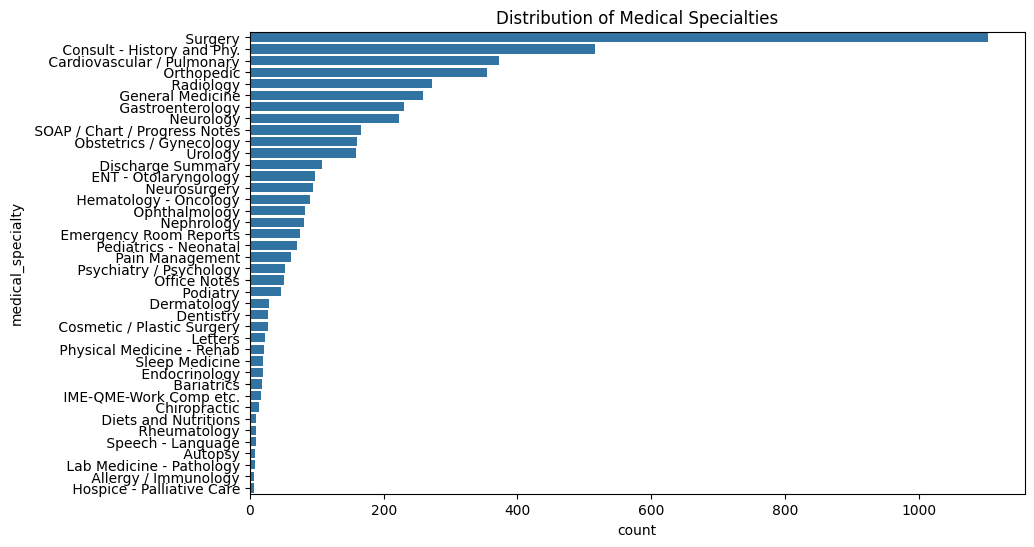

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/469 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/469 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/469 [00:00<?, ?it/s]

In [7]:
if __name__ == '__main__':
    # Path to your dataset
    file_path = '/content/drive/MyDrive/Colab_Notebooks/FemTherapeutics_Technical_Interview-main/DATA.csv'

    # Load and preprocess the data
    X_train, X_test, y_train, y_test, num_classes, class_weights, class_dict , df = load_data(file_path)

    # Train the RoBERTa model
    model = train_model(X_train, y_train, num_classes, class_weights)

    # Save the trained model
    model.save_model('./trained_model')



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

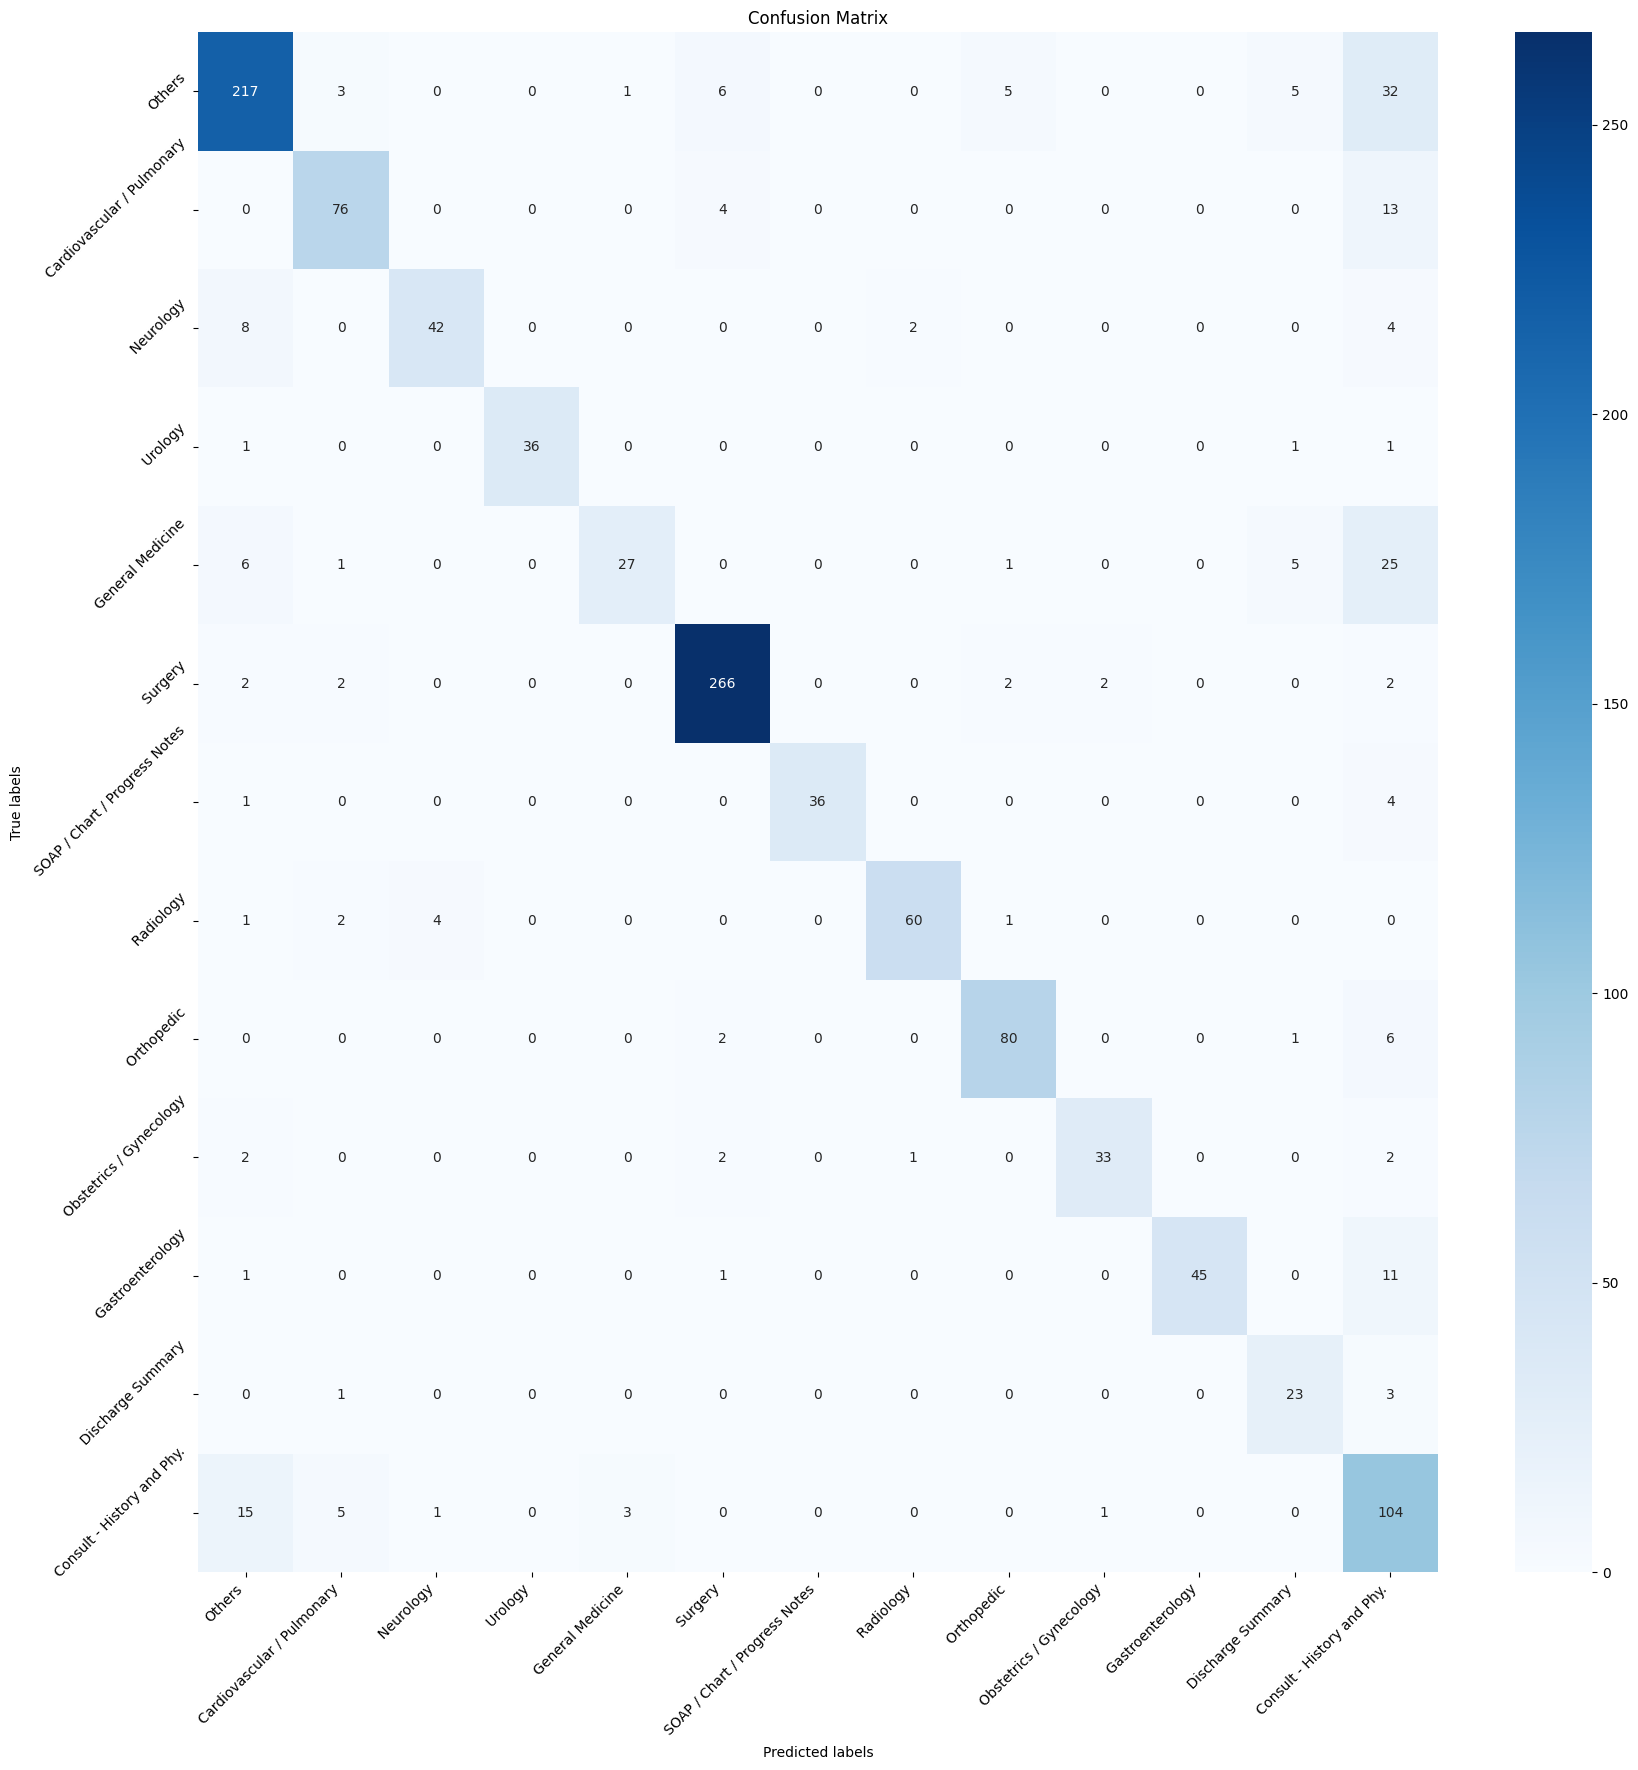

Balanced Accuracy: 0.8149476155889681, F1 Score: 0.8397502524243727


In [8]:
    # Evaluate the trained model on the test dataset
    evaluate_model(model, X_test, y_test, class_dict)



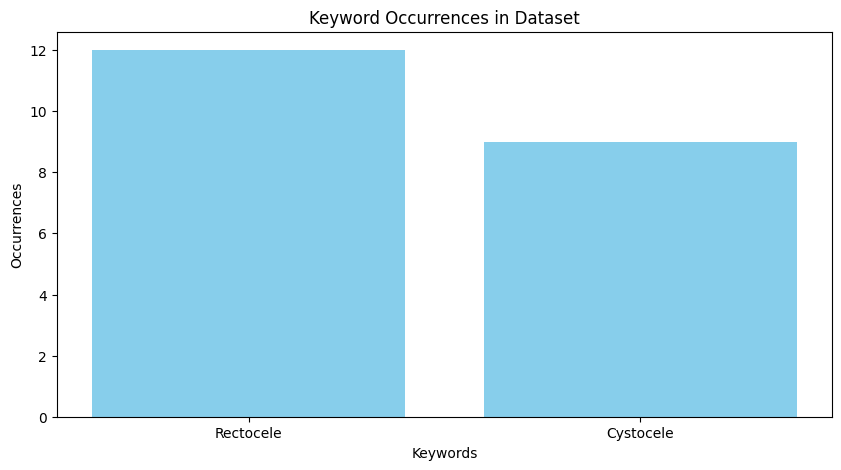

Occurrences of 'Rectocele': 12
Occurrences of 'Cystocele': 9


In [9]:
    # Analyze specific keywords in the dataset

    df['transcription'] = df['keywords'].fillna('') + ' ' + df['transcription'].fillna('')
    analyze_keywords(df, ['Rectocele', 'Cystocele'])

In [10]:
    df.head()
    #save df
    df.to_csv('preprocessed_df.csv')

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,0,Allergic Rhinitis,"allergy / immunology, allergic rhinitis, aller...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,0,Laparoscopic Gastric Bypass Consult - 2,"bariatrics, laparoscopic gastric bypass, weigh...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,0,Laparoscopic Gastric Bypass Consult - 1,"bariatrics, laparoscopic gastric bypass, heart...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,1,2-D Echocardiogram - 1,"cardiovascular / pulmonary, 2-d m-mode, dopple...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,1,2-D Echocardiogram - 2,"cardiovascular / pulmonary, 2-d, doppler, echo...","cardiovascular / pulmonary, 2-d, doppler, echo..."
